In [44]:
# Set up your matplotlib parameters so everything
# plots nicely

params = {"figure.figsize": (12,9),
          "font.size": 20,
          "font.weight": "normal",
          "xtick.major.size": 9,
          "xtick.minor.size": 4,
          "ytick.major.size": 9,
          "ytick.minor.size": 4,
          "xtick.major.width": 4,
          "xtick.minor.width": 3,
          "ytick.major.width": 4,
          "ytick.minor.width": 3,
          "xtick.major.pad": 8,
          "xtick.minor.pad": 8,
          "ytick.major.pad": 8,
          "ytick.minor.pad": 8,
          "lines.linewidth": 3,
          "lines.markersize": 10,
          "axes.linewidth": 4,
          "legend.loc": "best",
          "text.usetex": False,    
          "xtick.labelsize" : 20,
          "ytick.labelsize" : 20,
          }

import matplotlib
matplotlib.rcParams.update(params)

In [45]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.offsetbox import AnchoredText

import astropy as ap
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time

% matplotlib inline

In [46]:
def phase_up(ref_mjd, mjds, period):
    '''
    Phase up and fold a light curve
    
    Folds the MJDs of a light curve to a
    certain period (in days)
    and phases the MJDs to a specific MJD.
    
    Args:
    ref_mjd (float): the MJD that you are using as
                     your reference. Your light curve will
                     be phased to this MJD
    mjds (array): an array of floats, the MJDs of
                  your light curve
    period (float): the period (in days) that you are
                    folding to

    Returns:
    An array corresponding to the phase of each
    MJD after it has been folded and phased to
    ref_mjd.
    '''
    return (((mjds - ref_mjd)/period)-
            ((mjds - ref_mjd)//period))


def weighted_mean(values, uncertainties):
    '''
    Find the weighted mean of an array of values.
    
    Args:
    values (array): the array of values that you would
                    like to find the weighted mean of
    uncertainties (array): the array of uncertainties
                           corresponding to the values.
                           These will be used as the weights
    Returns:
    mean (float): the weighted mean of the values
    error (float): the uncertainty on the weighted mean
    '''
    # Find the weight of each value using the uncertainties
    weights = 1./(uncertainties**2)
    
    # Find the weighted mean of the values
    mean = (np.sum(values*weights))/(np.sum(weights))
    # Find the uncertainty on the weighted mean
    error = 1./(np.sqrt(np.sum(weights)))
    
    return mean, error

Add a quick and easy setting for whether you'd like to save the figures or not.

In [47]:
save_figures = False

Set up a colour and a marker for each season to use for every plot.

In [48]:
season_colours = ['#4363d8', '#911eb4', '#f032e6', '#e6194b', '#f58231', '#ffe119']
season_colours *= 6

season_markers = ['o', 's', '^', 'd']
season_markers *= 6

Load the optical observations that have been split
into semesters using <em>Process_Optical_Data.py</em>
(or <em>Process_Optical_Data.ipynb</em>) and the
period information from <em>LombScargle_Analysis.py</em>
(or <em>LombScargle_Analysis.ipynb</em>).

In [49]:
all_optical_info = np.load('TYC_optical_semesters.npy')
optical_mjd_chunks = all_optical_info[0]
optical_mag_chunks = all_optical_info[1]
optical_mag_e_chunks = all_optical_info[2]
optical_name_chunks = all_optical_info[3]

mean_all_V = np.mean(optical_mag_chunks[-1])

periods = np.load('TYC_LS_periods.npy')
period_errors = np.load('TYC_LS_periodErrors.npy')

Find the first MJD in each semester and sort the semesters
in order of their first MJD (this is because some semesters
overlap in time).

In [50]:
first_mjds = []
for i, time in enumerate(optical_mjd_chunks[:-1]):
    first_mjds.append(int(np.min(time)))
first_mjds = np.array(first_mjds)
time_order = np.argsort(first_mjds)

Make Figure 4 of the article. This is where we plot the results of the Lomb-Scargle analysis for each semester, and the results of the Lomb-Scargle analysis of all of the V-band observations together.

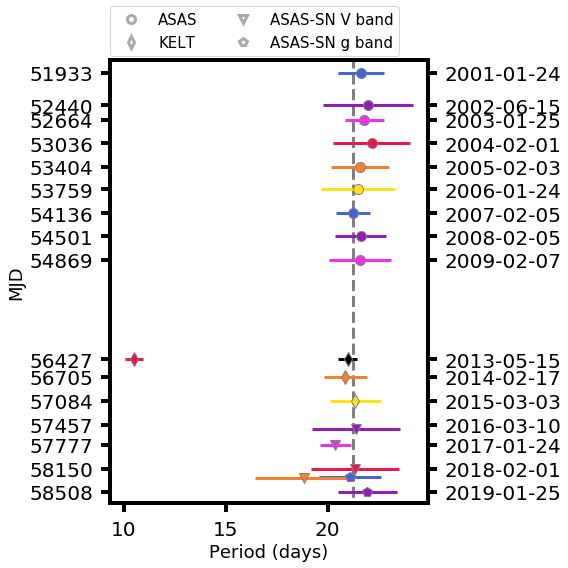

In [51]:
# Do you want to see what the period is
# for each semester? (False means no)
print_periods = False

# Set the frame colour and data point size
framecol= 'Black'
pointsize = 3

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for i, j in enumerate(time_order):
    if print_periods:
        # Print the information for each semester in order
        print((u'{0} \tperiod: {1:.4f} '
               '\u00B1 {2:.4f} days').format(optical_name_chunks[j],
                                             periods[j],
                                             period_errors[j]))
    # Make sure that each instrument has the
    # same marker style every time
    if optical_name_chunks[j]=='ASAS':
        m = 'o'
    elif optical_name_chunks[j]=='KELT':
        m = 'd'
    elif optical_name_chunks[j]=='ASAS-SN V':
        m = 'v'
    else:
        m = 'p'

    # Plot the period and uncertainty for the semester
    ax.errorbar(periods[j],
                int(np.min(optical_mjd_chunks[j])),
                xerr=period_errors[j],
                c=season_colours[j],
                marker=m,
                markeredgecolor='Grey')

    if periods[j] < 16:
        # One KELT season has more power in an harmonic,
        # so plot the real period here too.
        ax.errorbar(periods[j]*2,
                    int(np.min(optical_mjd_chunks[j])),
                    xerr=period_errors[j], fmt=m,
                    c=framecol, markeredgecolor='Grey')

# Plot the best period (from the Lomb-Scargle of
# all the V-band observations put together) as
# a grey dashed line
ax.plot(np.ones(10)*periods[-1],
        np.linspace(np.min(optical_mjd_chunks[-1])-500,
                    np.max(optical_mjd_chunks[-1])+500,
                    10), '--', c='Grey', zorder=0)

# Set all the ticks and spines to the frame colour
ax.tick_params(color=framecol, labelcolor=framecol)
for spine in ax.spines.values():
    spine.set_edgecolor(framecol)

# Label the left y-axis with the first MJD
# in each semester. I miss some semesters
# here so that the MJDs don't overlap
first_mjds = np.array([51933, 52440,
                       52664, 53036,
                       53404, 53759,
                       54136, 54501,
                       54869, 56427,
                       56705, 57084,
                       57457, 57777,
                       58150,
                       58508])
plt.yticks(first_mjds, first_mjds)
ax.set_xlabel('Period (days)', fontsize=18, color=framecol)

# Label the right y-axis with the date corresponding
# to the first MJD in each semester that is shown
# on the left y-axis
ymds = []
for date in Time(first_mjds.astype(float), format='mjd').isot:
    ymd = date[:date.index('T')]
    ymds.append(ymd)
ax2 = ax.twinx()
plt.yticks(first_mjds, ymds)

# Set the y-lim on both sides so everything
# lines up nicely
ax.set_ylim(np.min(optical_mjd_chunks[-1])-200,
            np.max(optical_mjd_chunks[-1])+300)
ax2.set_ylim(np.min(optical_mjd_chunks[-1])-200,
            np.max(optical_mjd_chunks[-1])+300)

ax.set_ylabel('MJD', fontsize=18, color=framecol)

# Make a legend that only shows the shape of
# the markers for each different instrument
asas_dot = mlines.Line2D([], [], color='None', marker='o',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+5, markeredgewidth=3,
                         label='ASAS')
kelt_dot = mlines.Line2D([], [], color='None', marker='d',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+5, markeredgewidth=3,
                         label='KELT')
asassnV_dot = mlines.Line2D([], [], color='None', marker='v',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+5, markeredgewidth=3,
                         label='ASAS-SN V band')
asassng_dot = mlines.Line2D([], [], color='None', marker='p',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+5, markeredgewidth=3,
                         label='ASAS-SN g band')
# Put the legend outside of the plot
leg0 = ax.legend(handles=[asas_dot, kelt_dot, asassnV_dot, asassng_dot],
                 fontsize=15, frameon=True, loc='lower left', ncol=2,
                 bbox_to_anchor= (0.0, 1.01), borderaxespad=0)

# Flip the y-axes
ax.invert_yaxis()
ax2.invert_yaxis()

plt.tight_layout()

if save_figures:
    # Save the figure how you like, but you do need
    # bbox_inches='tight' so that the legend isn't cut
    plt.savefig(('Optical_LombScargleResults_'
                 'FrameColour{}.eps').format(framecol),
                transparent=False,
                bbox_inches='tight')

### Now plot all of the folded semesters
This is Figure 5 of the paper, where we plot each semester folded to the best period and phased-up to the same MJD.

In [52]:
# The MJD that you're going to phase everything up to:
zero = 53571.094339999836
# The best period (from performing a Lomb-Scargle
# analysis on all of the V-band observations together)
best_period = periods[-1]
print('Period: {:.6f} days'.format(best_period))

Period: 21.254663 days


Get the optical data that has been binned such that there is one data point per day of observations.

In [53]:
binned_optical_data = np.load('TYC_optical_binned.npy')
# The MJDs of the data pints
binned_times = binned_optical_data[0]
# The magnitudes
binned_mags = binned_optical_data[1]
# The errors on the magnitudes
binned_errs = binned_optical_data[2]

Now plot

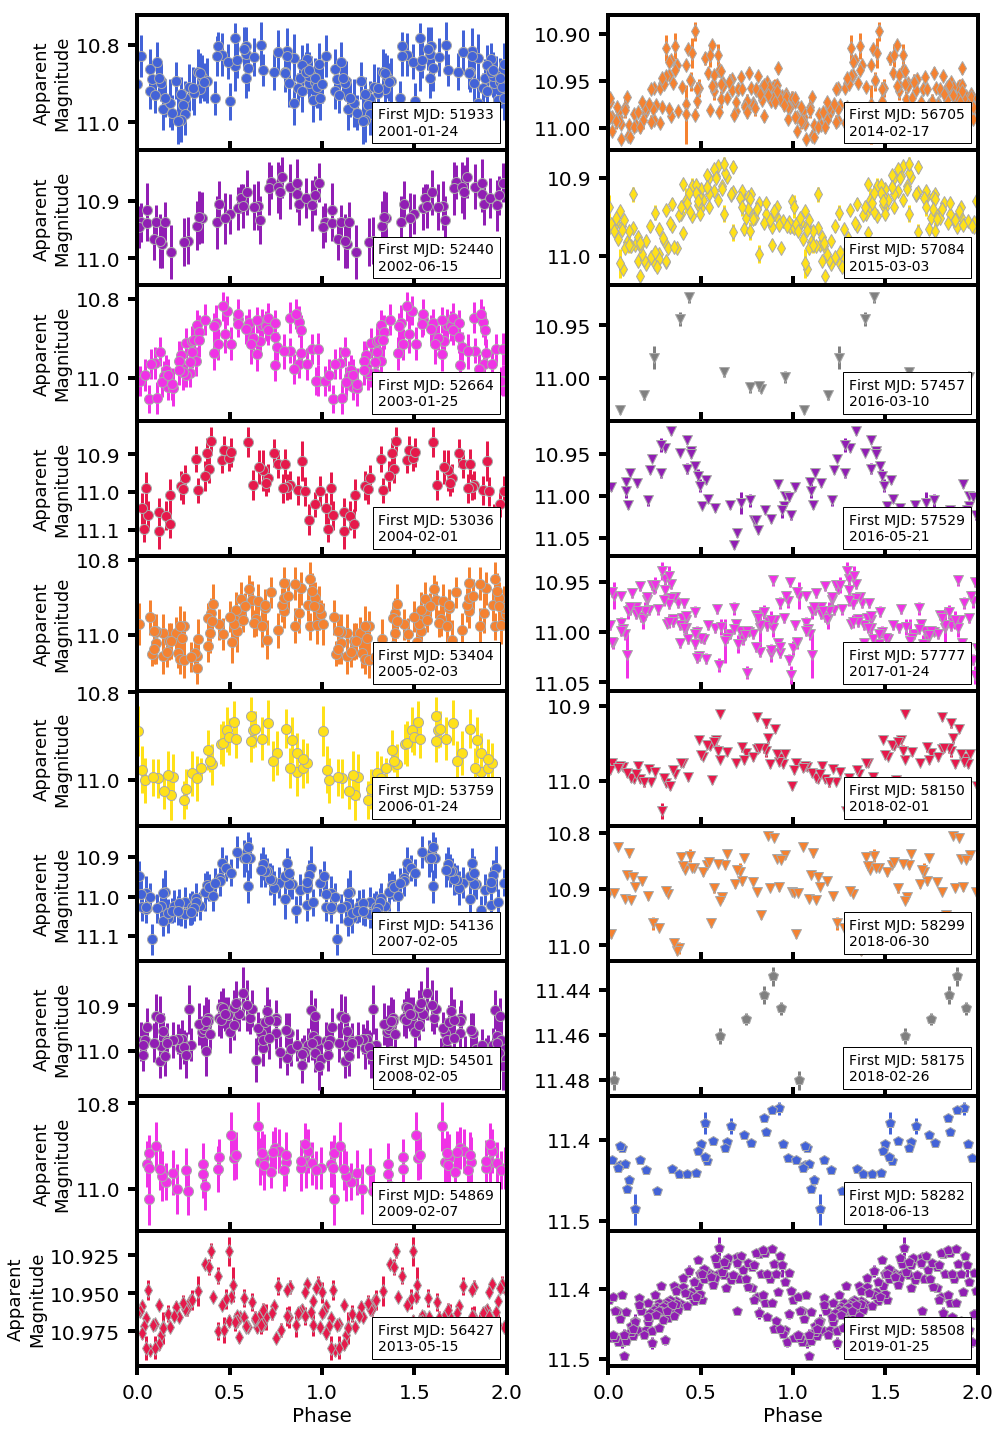

In [54]:
# Set the point colour
pointcolor = 'Black'
# Set the point size
pointsize = 10

# Set the number of subplots so that you have one
# per semester
fig, ax = plt.subplots(len(binned_times)//2, 2,
                       figsize=(14, 20))

for i, times in enumerate(binned_times):
    # Make sure that you keep the symbols consistent
    # for each instrument
    if optical_name_chunks[i]=='ASAS':
        m = 'o'
    elif optical_name_chunks[i]=='KELT':
        m = 'd'
    elif optical_name_chunks[i]=='ASAS-SN V':
        m = 'v'
    else:
        m = 'p'
    # This is so that the sub plots are in
    # order.
    if i < len(binned_times)//2:
        c = 0
        r = i
    else:
        c = 1
        r = i - (len(binned_times)//2)

    # Make a label that has the MJD
    # and ISOT date of the first data point
    # in the semester
    min_mjd = np.int(np.min(times))
    min_date = Time(min_mjd, format='mjd')
    min_date = (min_date.isot).split('T')[0]        
    info_text = AnchoredText((u'First MJD: {0}\n{1}').format(min_mjd, min_date),
                             loc='lower right', prop=dict(fontsize=14))
    # Be consistent with your colours for each season
    if len(optical_mag_chunks[i])>35:
        col = season_colours[i]
    else:
        # Some seasons are included that didn't have
        # enough data points to perform a Lomb-Scargle.
        # Colour these seasons grey
        col = 'Grey'

    btimes = np.array(binned_times[i])
    bmags = np.array(binned_mags[i])
    berrs = np.array(binned_errs[i])

    # Plot two folded periods by phasing the data
    # to the specified MJD and folding
    # to the best period
    ax[r, c].errorbar(phase_up(zero, btimes, best_period),
                      bmags,
                      yerr=berrs,
                      c=col, fmt=m,
                      markersize=pointsize, markeredgecolor='DarkGrey')
    ax[r, c].errorbar(phase_up(zero, btimes, best_period)+1,
                      bmags,
                      yerr=berrs,
                      c=col, fmt=m,
                      markersize=pointsize, markeredgecolor='DarkGrey')


    if np.int(np.min(times)) == 58150:
        ax[r, c].set_ylim(10.88, 11.06)

    # Since we're working with magnitudes, flip
    # the y-axis
    ax[r, c].invert_yaxis()

    ax[r, c].set_xlim(0, 2)
    # Add the label
    ax[r, c].add_artist(info_text)

    # Unless the plot is one of the bottom two plots,
    # you don't want x-tick labels, and you wan the
    # x-ticks to be inside the plot
    if ((r, c) != (len(binned_times)//2, 0) and
        (r, c) != (len(binned_times)//2 - 1, 0) and
        (r, c) != (len(binned_times)//2 - 1, 1)):
        ax[r, c].axes.get_xaxis().set_ticklabels([])
        ax[r, c].tick_params(axis='x', direction='in')
    # Give the plots on the left-hand column y-labels
    if c == 0:
        ax[r, c].set_ylabel('Apparent'+'\n'+'Magnitude', fontsize=18)

# For the bottom two plots, keep the x-tick-labels and
# label the x-axis
ax[len(binned_times)//2 - 1, 0].set_xlabel('Phase', fontsize=20)
ax[len(binned_times)//2 - 1, 1].set_xlabel('Phase', fontsize=20)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

if save_figures:
    plt.savefig('Optical_FoldedSemesters.eps')

### Plot the weighted mean fluxes for each semester

This is Figure 11 in the paper.

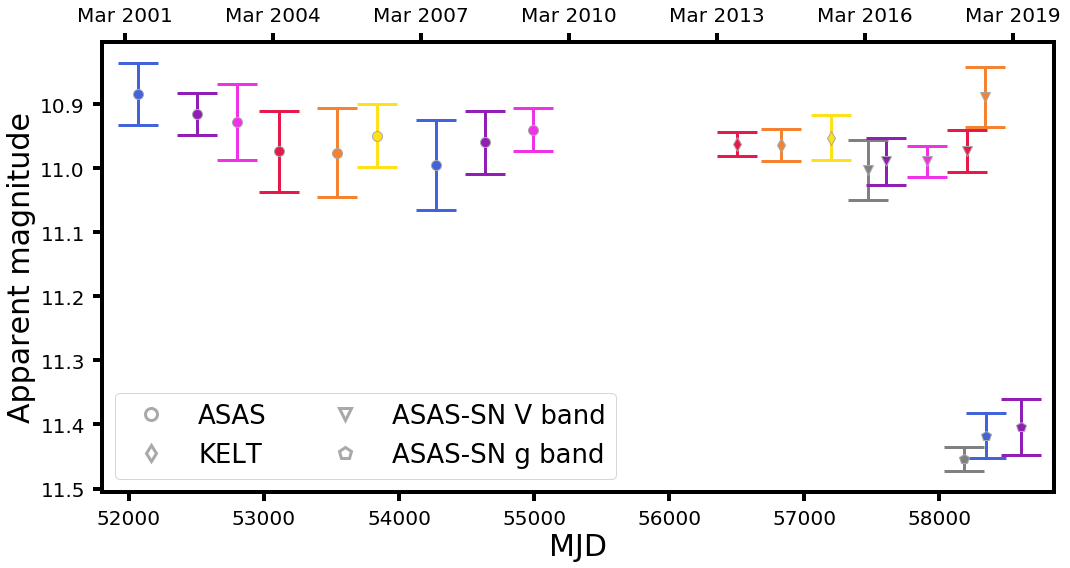

In [55]:
fig, ax = plt.subplots(figsize=(15, 8))

pointsize = 10
for i, time in enumerate(optical_mjd_chunks[:-1]):
    # Make sure that you keep the symbols consistent
    # for each instrument
    if optical_name_chunks[i]=='ASAS':
        m = 'o'
    elif optical_name_chunks[i]=='KELT':
        m = 'd'
    elif optical_name_chunks[i]=='ASAS-SN V':
        m = 'v'
    else:
        m = 'p'

    # Be consistent with your colours for each season
    if len(optical_mag_chunks[i])>35:
        col = season_colours[i]
    else:
        # Some seasons are included that didn't have
        # enough data points to perform a Lomb-Scargle.
        # Colour these seasons grey
        col = 'Grey'

    # Calculate the weighted mean and uncertainties on the weighted mean
    # for each semester
    wmean, werror = weighted_mean(optical_mag_chunks[i],
                                  optical_mag_e_chunks[i])
    (_, caps, _) = ax.errorbar((((np.max(time)-np.min(time))/2.)+
                                np.min(time)),
                               wmean,
                               yerr=np.std(optical_mag_chunks[i]),
                               c=col, fmt=m,
                               markeredgecolor='DarkGrey',
                               capsize=20)
    # Change the size of the lines on top of
    # the "errorbars"
    for cap in caps:
        cap.set_markeredgewidth(3)

ax.set_xlim(51800, 58850)

# Make some custom x-ticks so you can put
# the months on the top of the plot
ax2 = ax.twiny()
ax2.set_xticks([51969, 53065, 54160,
                55256, 56352, 57448, 58543])
ax2.set_xticklabels(['Mar 2001', 'Mar 2004',
                     'Mar 2007', 'Mar 2010',
                     'Mar 2013', 'Mar 2016',
                     'Mar 2019'])
ax2.set_xlim(51800, 58850)

# Make a custom legend
asas_dot = mlines.Line2D([], [], color='None', marker='o',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+2, markeredgewidth=3,
                         label='ASAS')
kelt_dot = mlines.Line2D([], [], color='None', marker='d',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+2, markeredgewidth=3,
                         label='KELT')
asassnV_dot = mlines.Line2D([], [], color='None', marker='v',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+2, markeredgewidth=3,
                         label='ASAS-SN V band')
asassng_dot = mlines.Line2D([], [], color='None', marker='p',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize+2, markeredgewidth=3,
                         label='ASAS-SN g band')
leg0 = ax.legend(handles=[asas_dot, kelt_dot, asassnV_dot, asassng_dot],
                 fontsize=26, frameon=True, loc='lower left', ncol=2)
# Because we're working with magnitudes, invert
# the y-axis
ax.invert_yaxis()

ax.set_ylabel('Apparent magnitude', fontsize=30)
ax.set_xlabel('MJD', fontsize=30)

plt.tight_layout()

if save_figures:
    plt.savefig('Optical_StandDevs.eps')

### Make the radial velocity plot

This is Figure 8. in the paper, showing the radial velocity compared to one of the optical semesters.

In [56]:
SALT_values = np.load('SALT_radial_velocities.npy')
LCO_values = np.load('LCO_radial_velocities.npy')

SALT_rv_jds = SALT_values[:, 0]
SALT_rv_times = Time(SALT_rv_jds, format='jd')
SALT_rv_mjds = SALT_rv_times.mjd

SALT_rvs = SALT_values[:, 1]
SALT_rv_errs = SALT_values[:, 2]

LCO_rv_jds = LCO_values[:, 0]
LCO_rv_times = Time(LCO_rv_jds, format='jd')
LCO_rv_mjds = LCO_rv_times.mjd

LCO_rvs = LCO_values[:, 1]
LCO_rv_errs = LCO_values[:, 2]

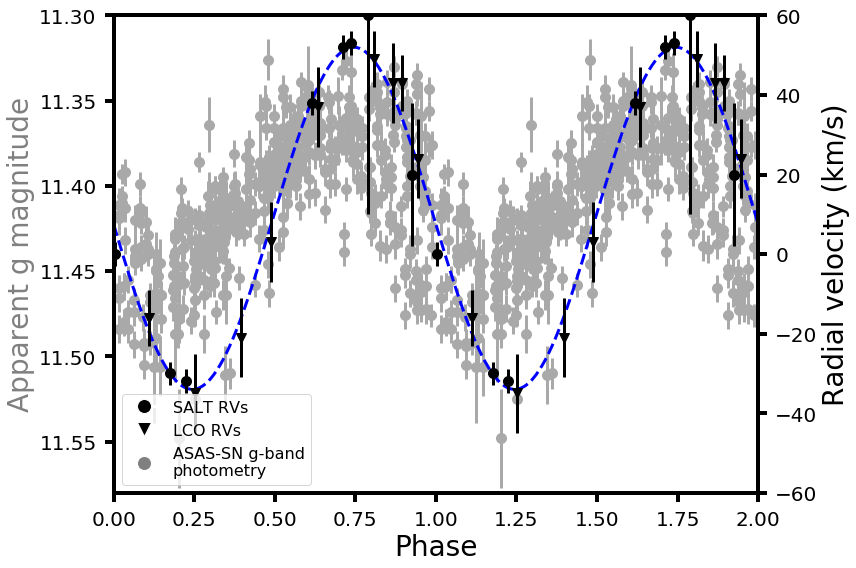

In [57]:
# Set the pointsize
pointsize = 10

# We want to plot just the most recent g-band
# ASAS-SN semester.
i = -2
times = optical_mjd_chunks[i]
mags = np.copy(optical_mag_chunks[i])
mag_e = np.copy(optical_mag_e_chunks[i])

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Make a a second y-axes to plot
# the RVs and optical magnitudes
# together
ax2 = ax1.twinx()

# On the first axis, plot the folded and phased
# optical magnitudes (two full periods)
ax1.errorbar(phase_up(zero, times, best_period),
             mags, yerr=mag_e,
             fmt='o', c='DarkGrey')
ax1.errorbar(phase_up(zero, times, best_period)+1,
             mags, yerr=mag_e,
             fmt='o', c='DarkGrey')

# Put the SALT and LCO radial velocities together
rv_mjds = np.concatenate((SALT_rv_mjds, LCO_rv_mjds))
rv_vals = np.concatenate((SALT_rvs, LCO_rvs))
rv_mjds = np.linspace(np.min(rv_mjds), np.max(rv_mjds), 256)
# Make a by-eye fit of the radial velocities
# with a sine curve
rv_ys = 43*np.sin(((2*np.pi)/best_period)*(rv_mjds+1.4)) + 9
rv_xs = phase_up(zero, rv_mjds, best_period)
# Put this in order so you can plot it
# as a line
rv_order = np.argsort(rv_xs)
# Plot the by-eye sine curve fit
ax2.plot(rv_xs[rv_order], rv_ys[rv_order],
         '--', c='Blue', zorder=0)
ax2.plot(rv_xs[rv_order]+1, rv_ys[rv_order],
         '--', c='Blue', zorder=0)
# Plot two periods of the SALT and LCO RVs folded to the same
# phase and period as the optical magnitudes
ax2.errorbar(phase_up(zero, SALT_rv_mjds, best_period),
             SALT_rvs, yerr=SALT_rv_errs,
             c='Black', fmt='o', label='SALT RVs')
ax2.errorbar(phase_up(zero, SALT_rv_mjds, best_period)+1,
             SALT_rvs, yerr=SALT_rv_errs,
             c='Black', fmt='o')
ax2.errorbar(phase_up(zero, LCO_rv_mjds, best_period),
             LCO_rvs, yerr=LCO_rv_errs,
             c='Black', fmt='v', label='LCO RVs')
ax2.errorbar(phase_up(zero, LCO_rv_mjds, best_period)+1,
             LCO_rvs, yerr=LCO_rv_errs,
             c='Black', fmt='v')

# Set the y limits so that the plots
# look nice
ax1.set_ylim(11.3, 11.58)
ax2.set_ylim(-60, 60)

# Add the labels and x limit. Make the colour
# of the x-labels match the colours of the
# plots
ax1.set_ylabel('Apparent g magnitude', fontsize=28, color='Grey')
ax2.set_ylabel('Radial velocity (km/s)', fontsize=28)
ax1.set_xlabel('Phase', fontsize=28)
ax1.set_xlim(0, 2)
ax2.set_xlim(0, 2)

# Make a legend
SALT_dot = mlines.Line2D([], [], markerfacecolor='Black', marker='o',
                         markersize=pointsize+4,
                         label='SALT RVs', color='w')
LCO_dot = mlines.Line2D([], [], markerfacecolor='Black', marker='v',
                         markersize=pointsize+4,
                         label='LCO RVs', color='w')
asassn_dot = mlines.Line2D([], [], markerfacecolor='Grey', marker='o',
                         markersize=pointsize+4,
                         label='ASAS-SN g-band'+'\n'+'photometry', color='w')
leg1 = ax2.legend(handles=[SALT_dot, LCO_dot, asassn_dot],
                 fontsize=16, frameon=True, loc='lower left')
# As the first axis has the magnitudes,
# flip the y-axis
ax1.invert_yaxis()

plt.tight_layout()

if save_figures:
    plt.savefig('RV_curve.eps', transparent=False)